## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sklearn.model_selection
import sklearn.metrics
import sklearn.ensemble
import seaborn as sns

from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#TODO: Remove this
warnings.filterwarnings('ignore') 

from tabulate import tabulate

%matplotlib inline

## Training and Predicting all Statistical Model

In [4]:
def run_prediction(data_set_file, bacteria_name, bacteria_short_name, antibiotic_name, Overall_Performance):
    
    # Datasets location
    data_sets_location = "./datasets/"

    # Load dataset into memory
    data_set = pd.read_csv(data_sets_location + data_set_file)

    # Split data into features and labels
    X = data_set.iloc[:, 2:-1]
    Y = data_set.iloc[:, -1]  # last column label

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, stratify=Y, test_size=0.25, random_state=42)

    # Create data frames for outputs
    Training_Performance = pd.DataFrame(columns=['classifier', 'Train set size', 'Susceptible', 'Resistant', 'train_f1', 'train_recall', 'train_precision'])
    Test_Performance = pd.DataFrame(columns=['classifier','Test set size', 'Susceptible', 'Resistant', 'test_f1', 'test_recall', 'test_precision'])
    Tf_CV = pd.DataFrame(columns=[])
    Area_Under_ROC = pd.DataFrame(columns=[])
    Area_Under_Precision_Recall = pd.DataFrame(columns=[])
    Model_Predict = pd.DataFrame(columns=[])

    # Add all the models models
    models = []
    models.append(('LogR', LogisticRegression()))
    models.append(('gNB', GaussianNB()))
    models.append(('SVM', SVC(kernel='rbf', probability=True)))
    models.append(('DT', DecisionTreeClassifier(
        criterion='entropy', random_state=1)))
    models.append(('RF', RandomForestClassifier(
        n_estimators=10, criterion='entropy', random_state=0)))
    models.append(('KNN', KNeighborsClassifier(
        n_neighbors=5, metric='minkowski', p=2)))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('mNB', MultinomialNB()))
    models.append(('ABC', AdaBoostClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    models.append(('ETC', ExtraTreesClassifier()))
    models.append(('BC', BaggingClassifier()))

    high_score_model_name = ""
    max_model_f1_score = 0
    max_model_recall = 0
    max_model_precision = 0
    max_model_test_y = pd.DataFrame()
    max_model_test_y_pred = pd.DataFrame()


    # Evaluating all the models
    for model_name, model in models:
        model = model.fit(X_train, Y_train)
        
        #Train performance
        Y_train_pred = model.predict(X_train)
        Train_precision = precision_score(Y_train, Y_train_pred, average='macro').round(3)
        Train_recall = recall_score(Y_train, Y_train_pred, average='macro').round(3)
        Train_f1 = f1_score (Y_train, Y_train_pred, average='macro').round(3)
        Training_Performance.loc[len(Training_Performance)] = [model_name, len(X_train), Y_train.value_counts()[0], Y_train.value_counts()[1], Train_f1, Train_recall, Train_precision]
        
        #Test performance
        Y_test_pred = model.predict(X_test)
        Test_precision = precision_score(Y_test, Y_test_pred, average='macro').round(3)
        Test_recall = recall_score(Y_test, Y_test_pred, average='macro').round(3)
        Test_f1 = f1_score (Y_test, Y_test_pred, average='macro').round(3)
        Test_Performance.loc[len(Test_Performance)] = [model_name, len(X_test), Y_test.value_counts()[0], Y_test.value_counts()[1], Test_f1, Test_recall, Test_precision]

        # Keeping track of highest accuracy model
        if(max_model_f1_score < Test_f1):
            max_model_f1_score = Test_f1
            high_score_model_name = model_name    
            max_model_recall = Test_recall
            max_model_precision = Test_precision
            max_model_test_y_pred = Y_test_pred
            max_model_test_y = Y_test

    # Appending the dataset details and best model details into the overall dataframe 
    Overall_Performance.loc[len(Overall_Performance)] = [data_set_file, bacteria_name, antibiotic_name, len(X_train), Y_train.value_counts()[0], Y_train.value_counts()[1],len(X_test), Y_test.value_counts()[0], Y_test.value_counts()[1], high_score_model_name, max_model_f1_score, max_model_recall, max_model_precision]

    # Printing the confusion matrix
    cf_matrix = confusion_matrix(max_model_test_y, max_model_test_y_pred)
    plt.figure()
    ax = plt.axes()
    ax.set_title(f"Dataset:{data_set_file} Model:{high_score_model_name}")
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.show()


    # ROC and AUC

    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(max_model_test_y, max_model_test_y_pred)

    # Calculate the AUC score
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"Dataset:{data_set_file} Model:{high_score_model_name} ROC-CURVE")
    plt.legend(loc="lower right")
    plt.show()
    

## Driver Code

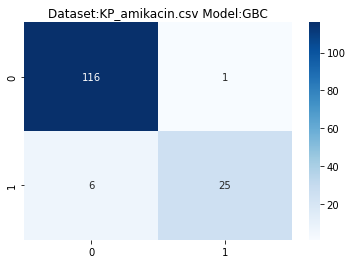

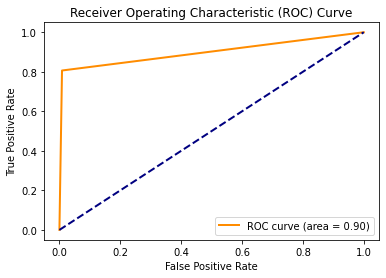

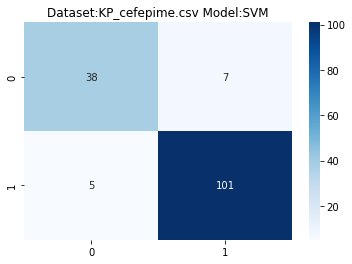

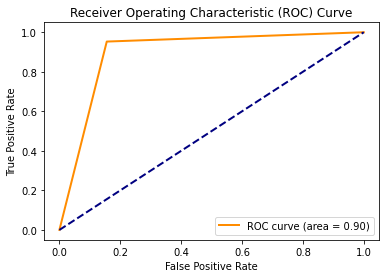

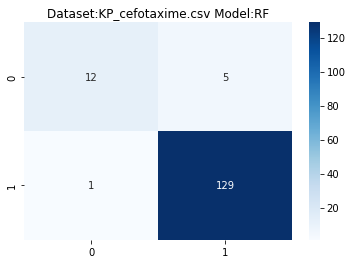

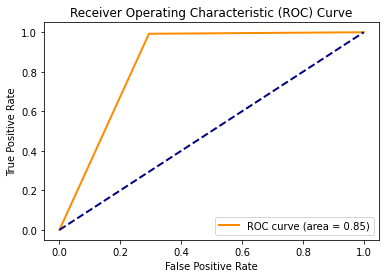

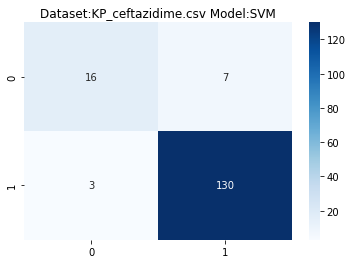

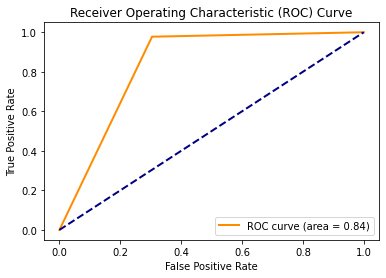

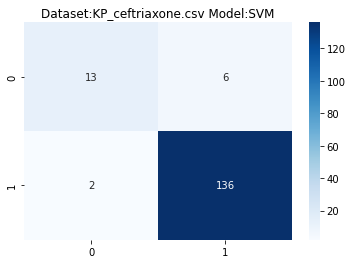

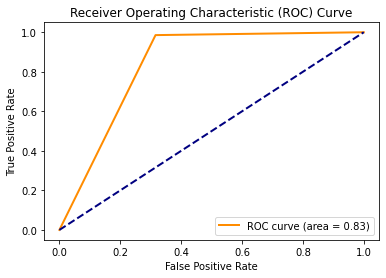

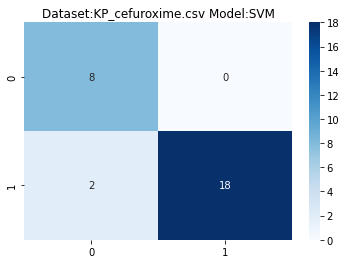

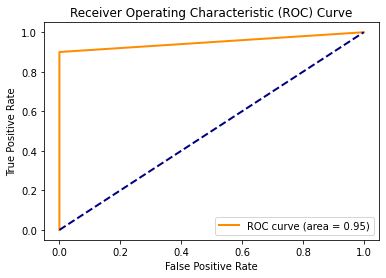

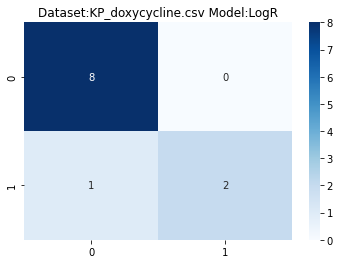

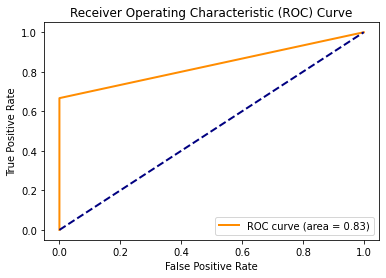

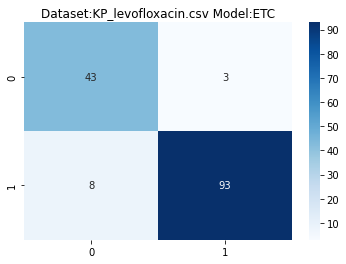

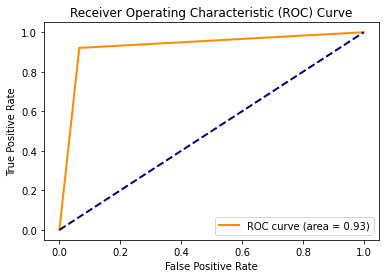

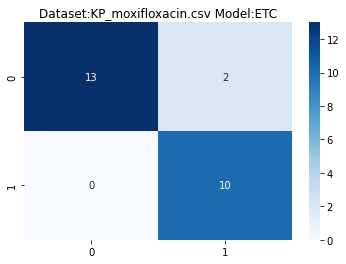

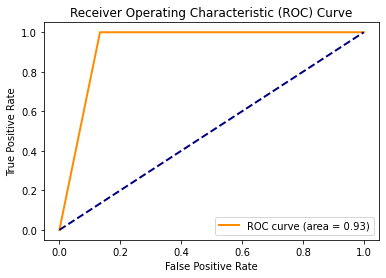

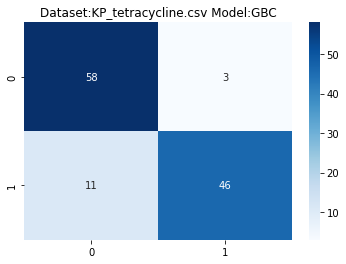

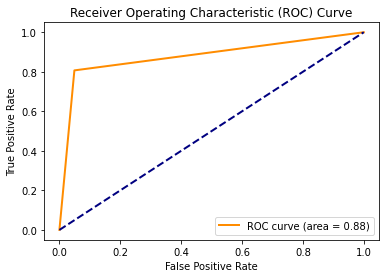

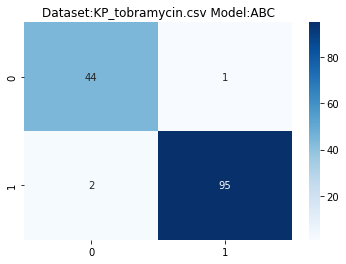

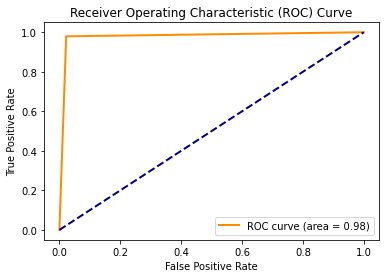

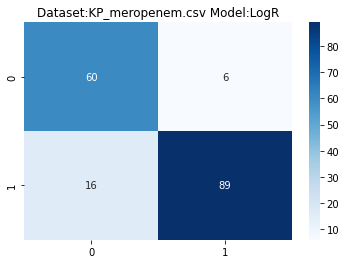

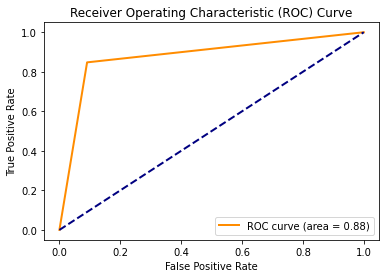

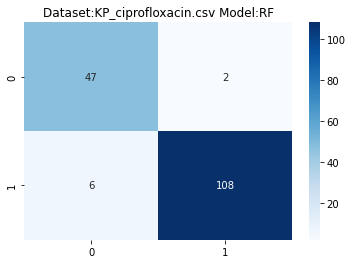

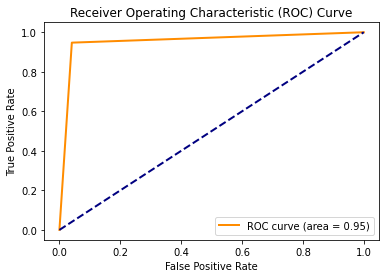

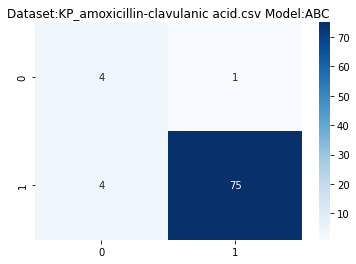

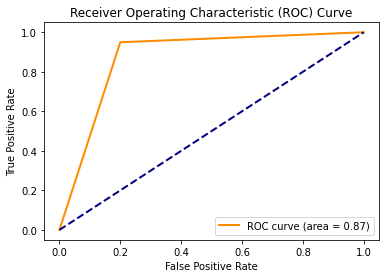

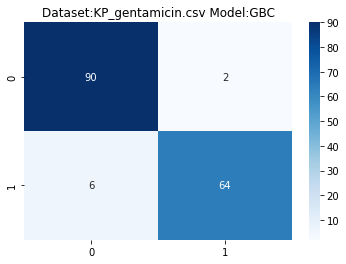

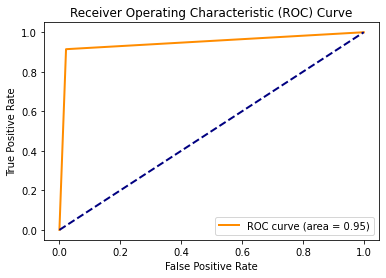

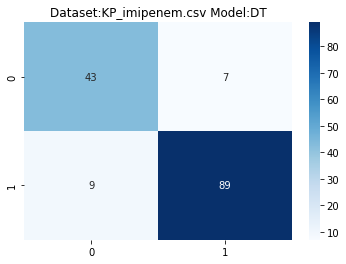

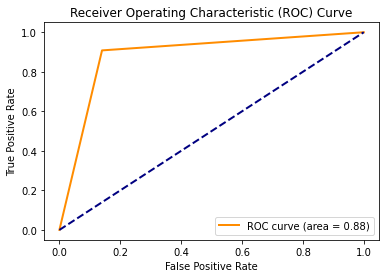

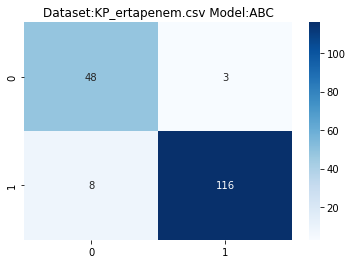

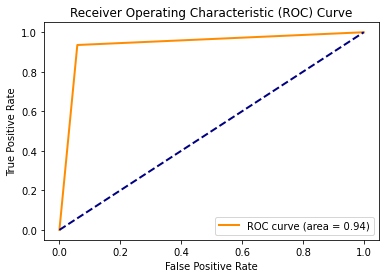

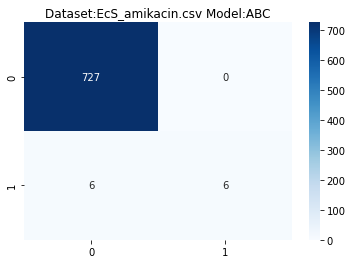

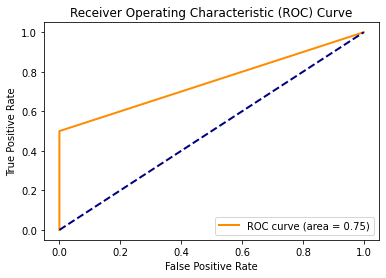

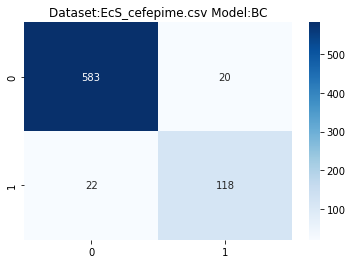

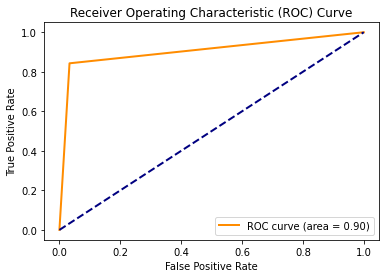

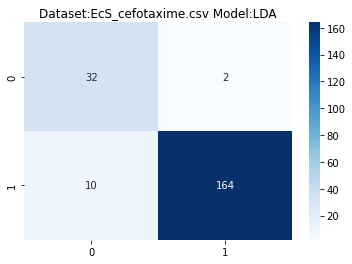

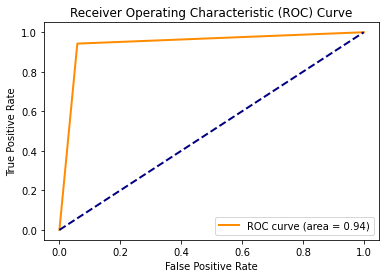

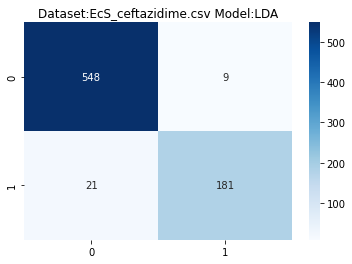

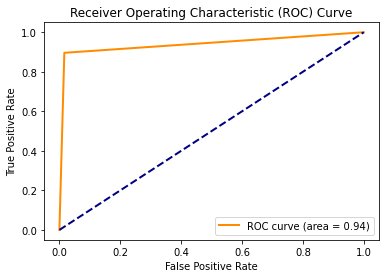

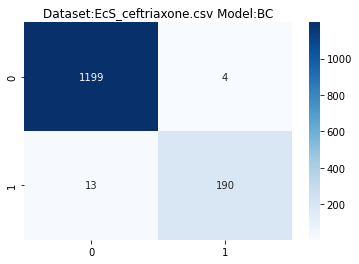

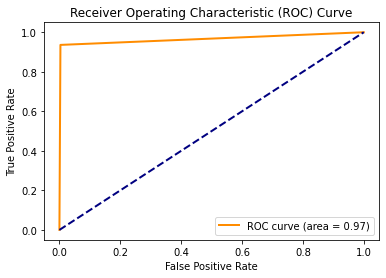

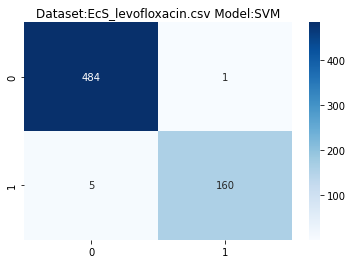

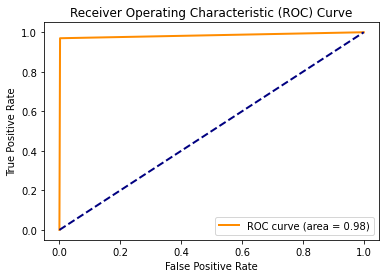

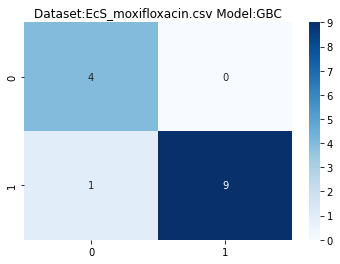

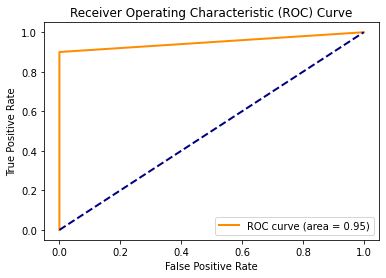

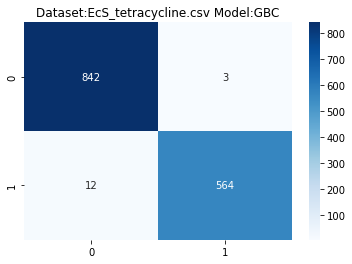

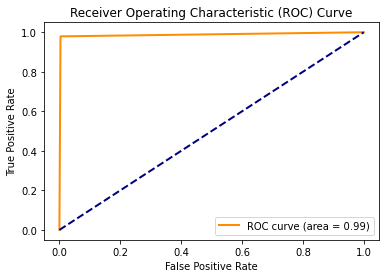

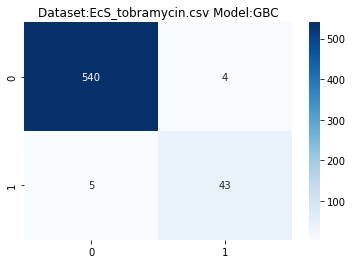

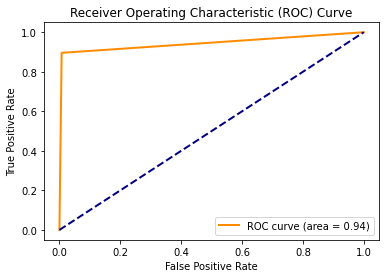

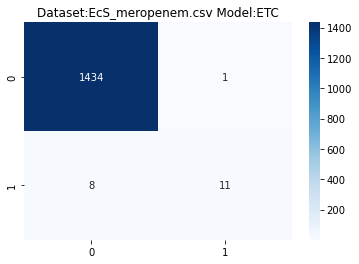

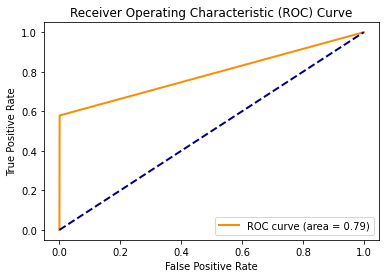

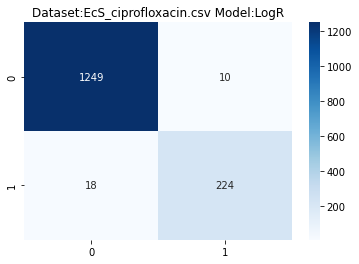

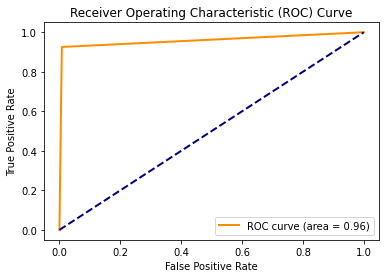

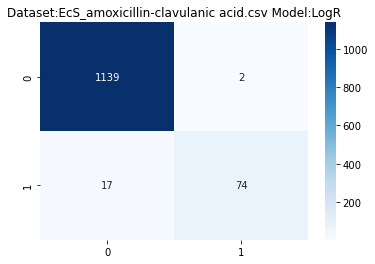

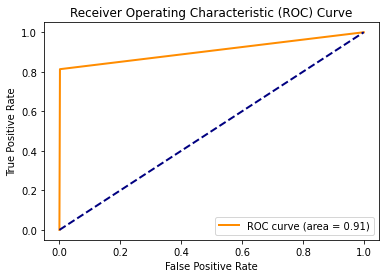

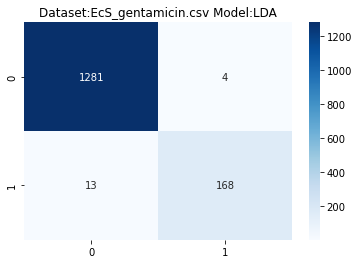

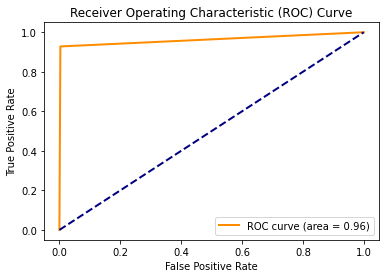

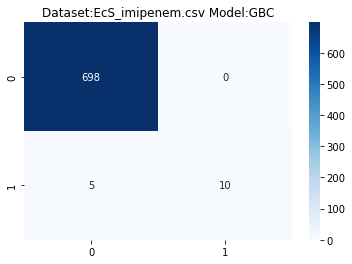

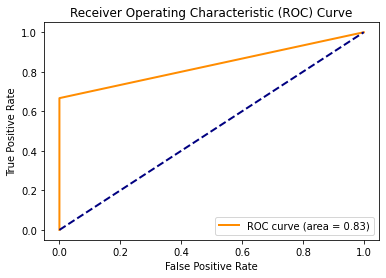

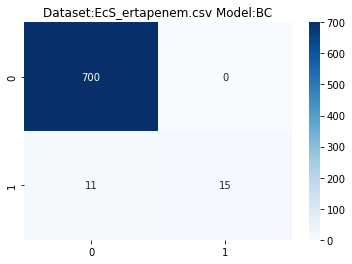

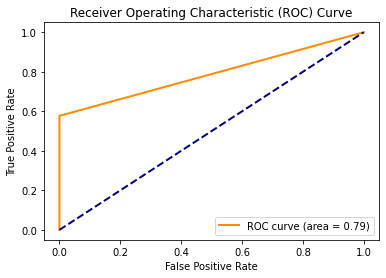

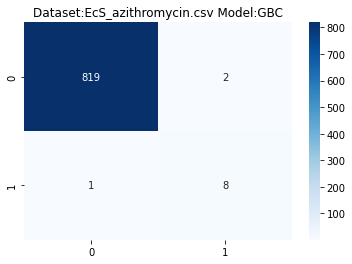

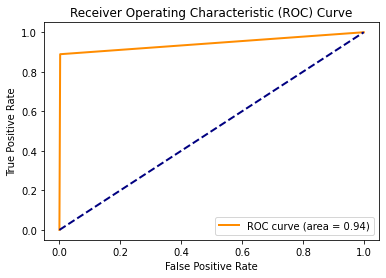

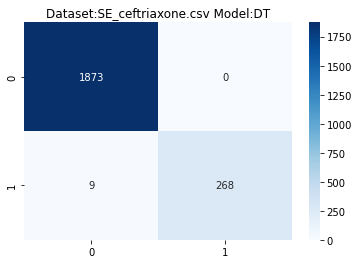

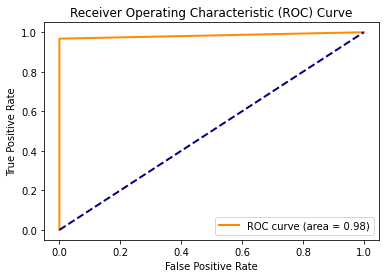

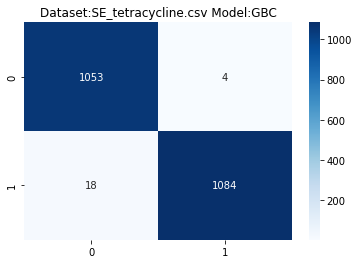

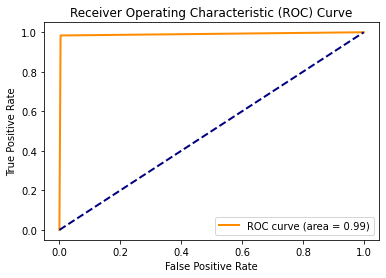

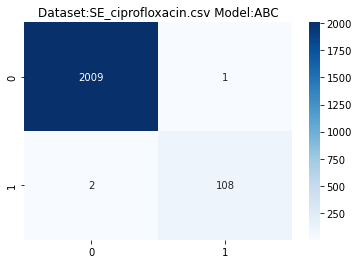

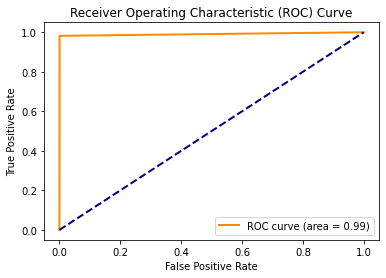

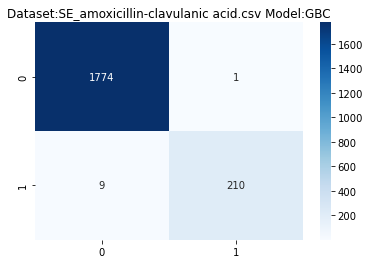

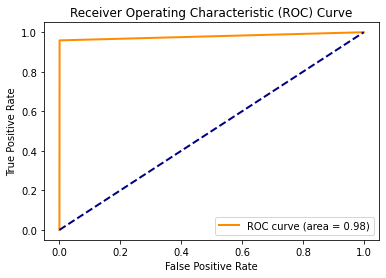

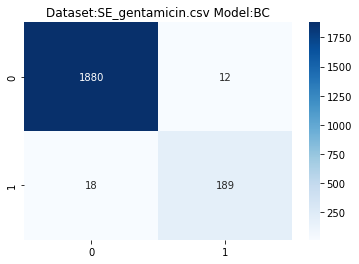

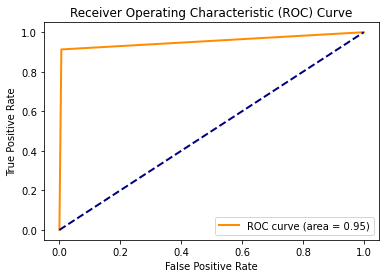

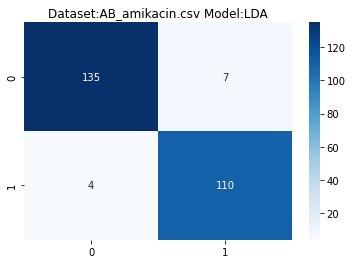

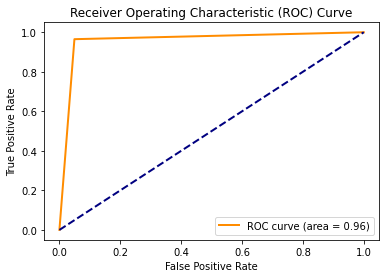

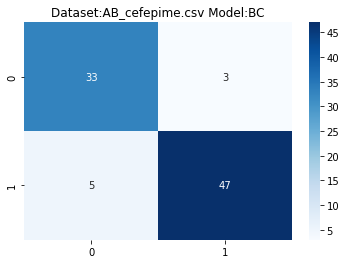

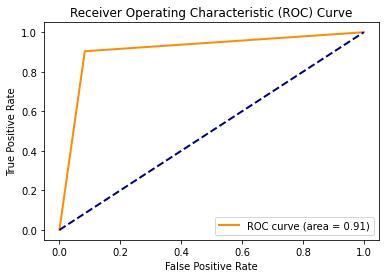

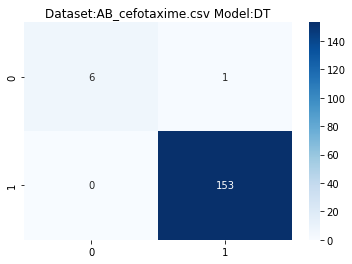

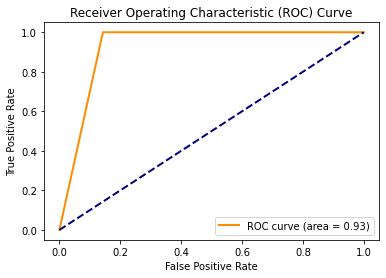

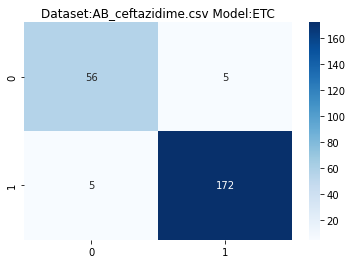

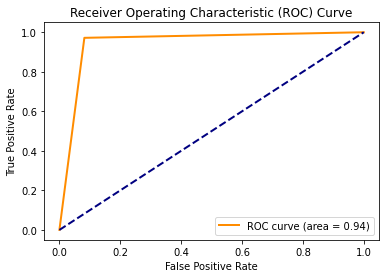

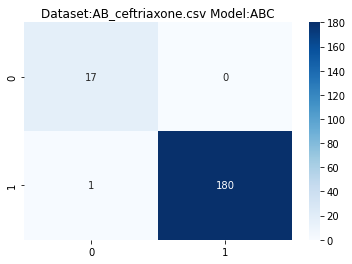

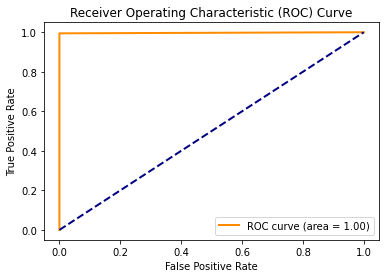

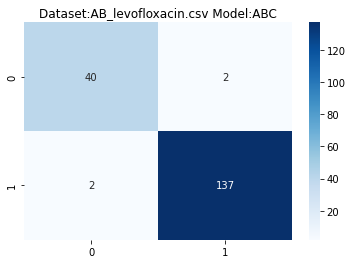

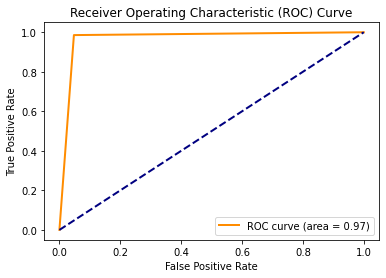

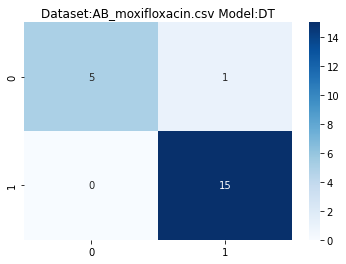

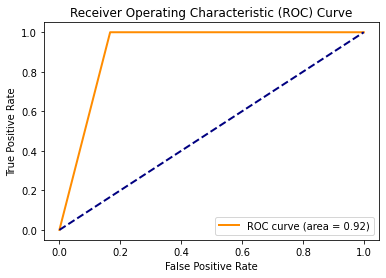

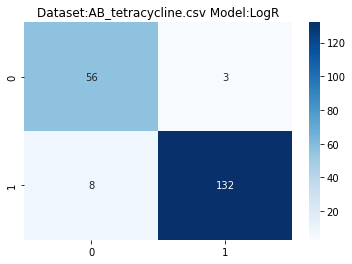

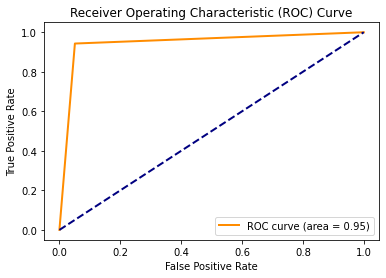

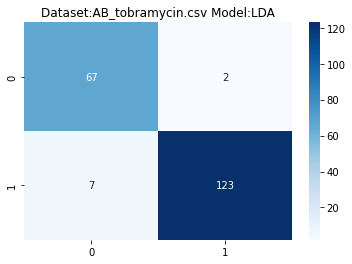

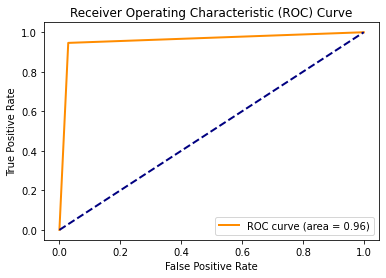

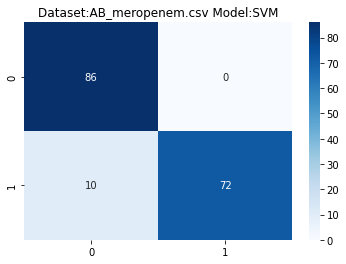

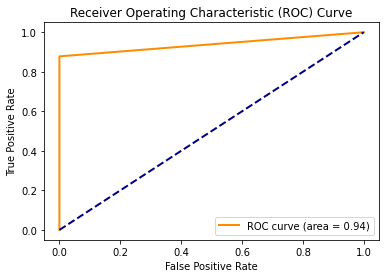

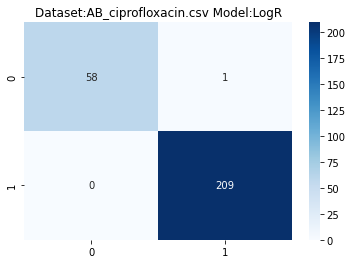

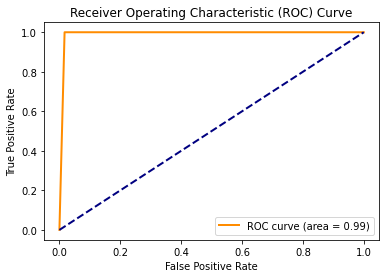

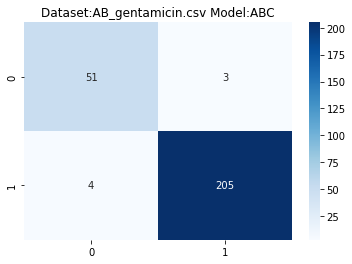

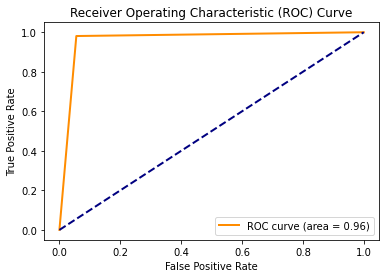

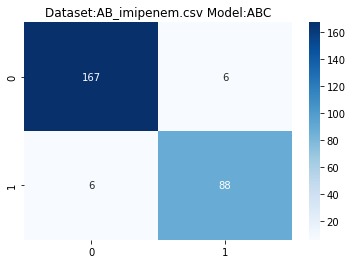

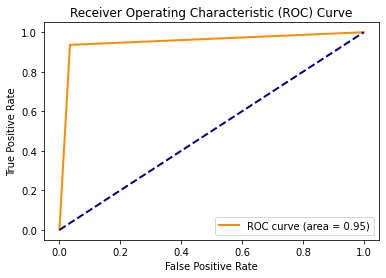

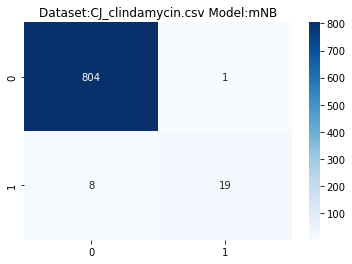

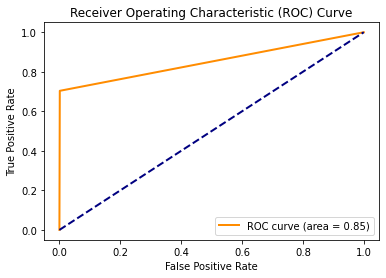

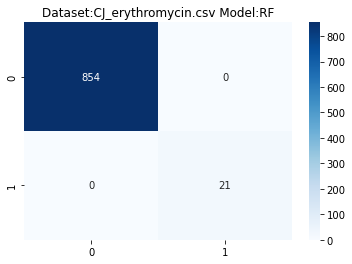

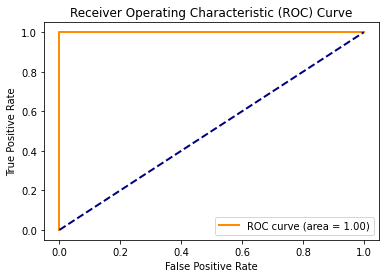

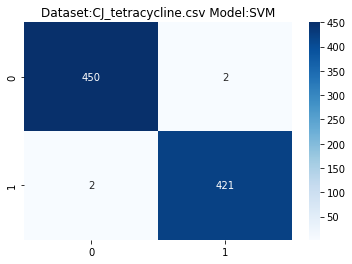

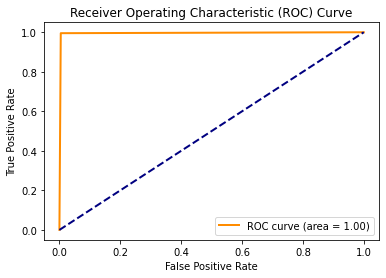

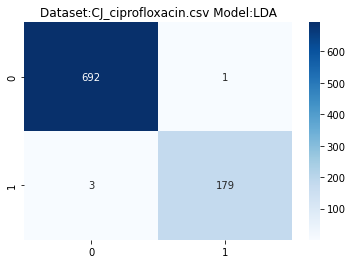

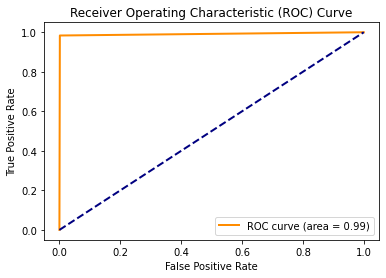

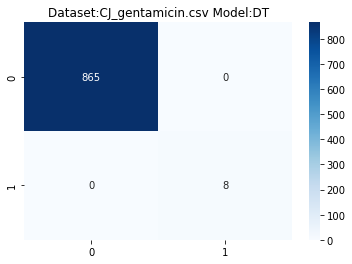

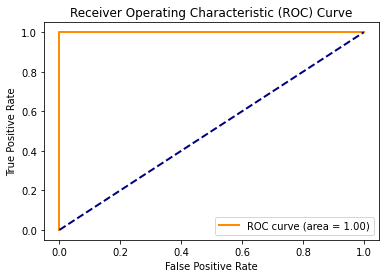

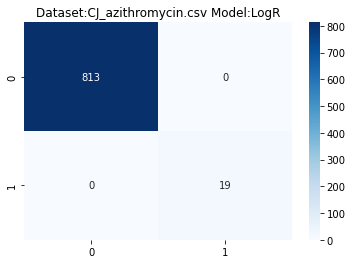

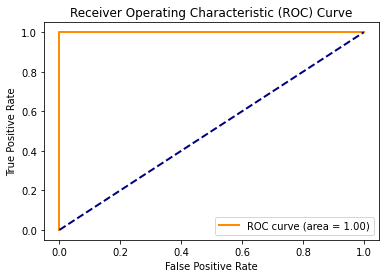

,Dataset Name,Bacteria Name,Antibiotic Name,Train set size,Susceptible,Resistant,Test set size,Susceptible,Resistant,Best Performing Classifier,Best F1 Score,Recall,Precision
0,KP_amikacin.csv,Klebsiella pneumoniae,amikacin,443,351,92,148,117,31,GBC,0.924,0.899,0.956
1,KP_cefepime.csv,Klebsiella pneumoniae,cefepime,453,134,319,151,45,106,SVM,0.904,0.899,0.909
2,KP_cefotaxime.csv,Klebsiella pneumoniae,cefotaxime,438,50,388,147,17,130,RF,0.889,0.849,0.943
3,KP_ceftazidime.csv,Klebsiella pneumoniae,ceftazidime,466,67,399,156,23,133,SVM,0.862,0.837,0.896
4,KP_ceftriaxone.csv,Klebsiella pneumoniae,ceftriaxone,470,57,413,157,19,138,SVM,0.868,0.835,0.912
5,KP_cefuroxime.csv,Klebsiella pneumoniae,cefuroxime,84,24,60,28,8,20,SVM,0.918,0.950,0.900
6,KP_doxycycline.csv,Klebsiella pneumoniae,doxycycline,31,22,9,11,8,3,LogR,0.871,0.833,0.944
7,KP_levofloxacin.csv,Klebsiella pneumoniae,levofloxacin,439,137,302,147,46,101,ETC,0.915,0.928,0.906
8,KP_moxifloxacin.csv,Klebsiella pneumoniae,moxifloxacin,75,43,32,25,15,10,ETC,0.919,0.933,0.917
9,KP_tetracycline.csv,Klebsiella pneumoniae,tetracycline,352,181,171,118,61,57,GBC,0.880,0.879,0.890


In [5]:
# Importing datasets
data_sets = pd.read_csv("./datasets_info.csv")
Overall_Performance = pd.DataFrame(columns=["Dataset Name", "Bacteria Name", "Antibiotic Name", "Train set size", 'Susceptible', 'Resistant', 'Test set size', 'Susceptible', 'Resistant', "Best Performing Classifier", "Best F1 Score", "Recall", "Precision"])

# Iterating on all datasets to find corresponding best model
for index, row in data_sets.iterrows():
    run_prediction(data_sets["Dataset Name"][index], data_sets["Bacteria Name"][index], data_sets["Bacteria Short Name"][index], data_sets["Antibiotic Name"][index], Overall_Performance)

# Exporting best model details for all datasets in a sheet
Overall_Performance.to_csv("Best_statistical_model_on_all_datasets.csv")

# Print best model details in the cell
Overall_Performance